In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

In [135]:
X, y = make_regression(n_samples=10000, noise=200, random_state=42)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_calib, y_test, y_calib = train_test_split(X_remaining, y_remaining, test_size=0.50, random_state=42)
del X_remaining, y_remaining

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Calibration set size:", X_calib.shape)

Training set size: (6000, 100)
Test set size: (2000, 100)
Calibration set size: (2000, 100)


In [136]:
model = lgb.LGBMRegressor(n_estimators=100, min_child_samples=500)
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)
r2_train = r2_score(y_train, yhat_train)
rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
r2_test = r2_score(y_test, yhat_test)
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))

print("Training set r2:", round(r2_train, 2))
print("Training set rmse:", round(rmse_train, 2))
print("Test set r2:", round(r2_test, 2))
print("Test set rmse:", round(rmse_test, 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 100
[LightGBM] [Info] Start training from score 1.135316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

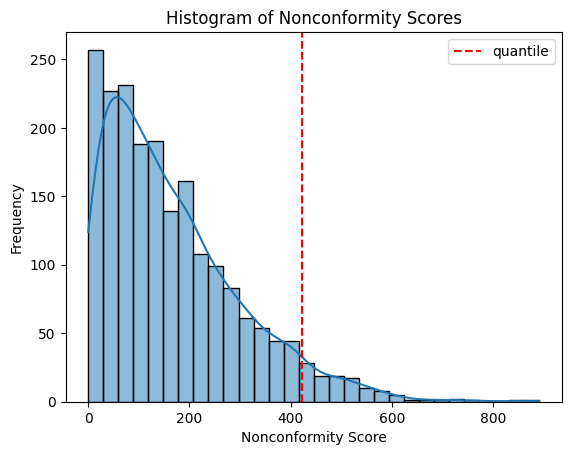

In [137]:
yhat_calib = model.predict(X_calib)
nonconformity_calib = np.abs(y_calib - yhat_calib)
q_yhat_cal = np.quantile(nonconformity_calib, 0.95)

sns.histplot(nonconformity_calib, kde=True, bins=30)
plt.axvline(x=q_yhat_cal, color='r', linestyle='--', label='quantile')
plt.legend()
plt.title('Histogram of Nonconformity Scores')
plt.xlabel('Nonconformity Score')
plt.ylabel('Frequency')
plt.show()

In [171]:
yhat_test_lower = yhat_test - q_yhat_cal
yhat_test_upper = yhat_test + q_yhat_cal

df_test = pd.DataFrame(list(zip(y_test, yhat_test, yhat_test_lower, yhat_test_upper)), columns=['actual', 'predicted', 'lower_bound', 'upper_bound'])
df_test['width'] = np.abs(df_test['upper_bound'] - df_test['lower_bound'])
df_test['within_interval'] = np.where((df_test['actual'] >= df_test['lower_bound']) & (df_test['actual'] <= df_test['upper_bound']), 1, 0)
df_test['percentiles'] = pd.qcut(df_test['predicted'], q=100, labels=False)
min_width = df_test['width'].min()
max_width = df_test['width'].max()
coverage = df_test['within_interval'].sum() / len(df_test)

print("Minimum width:", round(min_width))
print("Maximum width:", round(max_width))
print("Percentage of observations where the actual value is within the prediction intervals:", round(coverage, 2))

Minimum width: 847
Maximum width: 847
Percentage of observations where the actual value is within the prediction intervals: 0.96


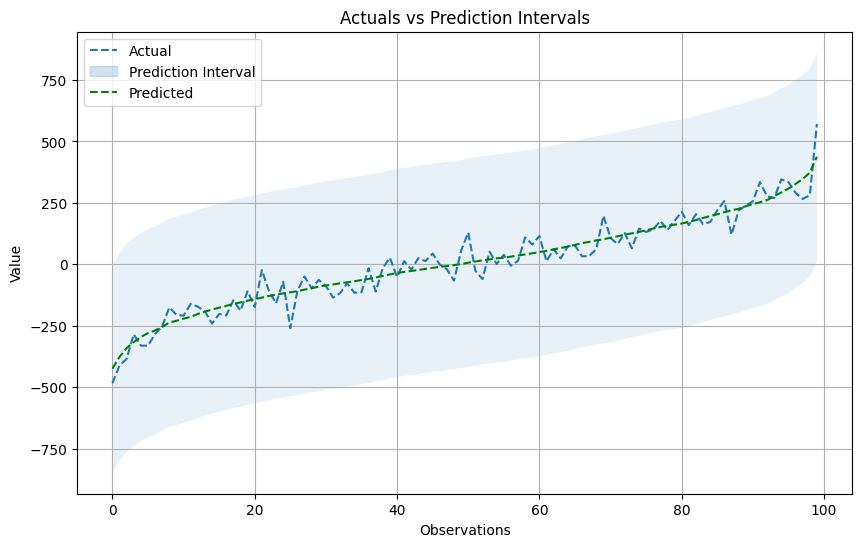

In [182]:
df_test_summary = df_test.groupby('percentiles').agg({
    'actual': 'mean',
    'predicted': 'mean',    
    'lower_bound': 'mean',
    'upper_bound': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_test_summary['actual'], linestyle='--', label='Actual')
plt.plot(df_test_summary['percentiles'], df_test_summary['predicted'], color='green', linestyle='--', label='Predicted')
plt.fill_between(df_test_summary['percentiles'], df_test_summary['lower_bound'], df_test_summary['upper_bound'], alpha=0.1, label='Prediction Interval')
plt.title('Actuals vs Prediction Intervals')
plt.xlabel('Observations')
plt.ylabel('Value')
plt.legend(['Actual', 'Prediction Interval', 'Predicted'])
plt.grid(True)
plt.show()